In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import pygimli as pg
from pygimli.viewer.mpl import drawModel1D
import matplotlib.pyplot as plt
import pyproj
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

## Input Data & Pre-Processing

In [2]:
# Read in the satellite image
sat_img = rioxarray.open_rasterio("..\Data\Basemap\geo_reference\Georef.tif")
sat_img = sat_img.rename({"x": "easting", "y": "northing"})

In [3]:
# Read in the MODIS data
modis_files = ["..\Data\MODIS\LST2001.csv", "..\Data\MODIS\LST2019.csv"]
modis_dfs = []

for file in modis_files:
    df = pd.read_csv(file)
    
    year = df['Year'].iloc[0]
    
    # Convert the date column to a datetime object
    base_date = pd.to_datetime(f'{year}-01-01')
    df['Date'] = base_date + pd.to_timedelta(df['Day'], unit='D')
    
    df['Easting'] = df['Easting'].astype(int)
    df['Northing'] = df['Northing'].astype(int)
    
    modis_dfs.append(df)

modis_df = pd.concat(modis_dfs)

# Remove duplicates
modis_df = modis_df.drop_duplicates(subset=['Date', 'Easting', 'Northing'], keep='last')

# Create a multi-index
idx = pd.MultiIndex.from_product(
    [modis_df["Date"].unique(), modis_df["Northing"].unique(), modis_df["Easting"].unique()],
    names=["time", "northing", "easting"]
)

# Reshape the dataframe
modis_df_reshaped = modis_df.set_index(["Date", "Northing", "Easting"]).reindex(idx, fill_value=np.nan).reset_index()

# Convert to xarray
modis_data = modis_df_reshaped.set_index(['time', 'northing', 'easting']).to_xarray()

modis_data = modis_data[['LST_day', 'LST_night', 'NDVI', 'EVI']]

In [4]:
# Define the positions
positions_coords = {
    "P1": (-1.58846584, 54.75258489),
    "P2": (-1.58921989, 54.75265542)
}

# Project the positions
inp = pyproj.CRS('epsg:4326')
out = pyproj.CRS('epsg:27700')

# Create a transformer
transformer = pyproj.Transformer.from_crs(inp, out, always_xy=True)

# Project the positions
projected_positions = {}
for key, coords in positions_coords.items():
    easting, northing = transformer.transform(*coords)
    projected_positions[key] = (easting, northing)

In [5]:
# Read in the resistivity data
res_files = ["..\Data\Resistivity\input_position_1.csv", "..\Data\Resistivity\input_position_2.csv"]
res_data = []

for i, file in enumerate(res_files):
    df = pd.read_csv(file)

    def clean_and_process_data(row):
        measurements = row[['m1', 'm2', 'm3', 'm4']]
        valid_measurements = measurements[measurements >= 0]
        
        # Remove outliers
        if len(valid_measurements) < 3:
            return None
        
        mean = valid_measurements.mean()
        std_dev = valid_measurements.std()
        return pd.Series([mean, std_dev], index=['mean', 'std_dev'])

    # Apply the function to each row
    df[['mean', 'std_dev']] = df.apply(clean_and_process_data, axis=1)
    df.dropna(inplace=True)
    
    # Create the inversion
    nlay = 6
    f = pg.core.DC1dModelling(nlay, df["c"], df["p"])
    paraDepth = max(df["c"]) / 2.
    f.region(0).setStartValue(paraDepth / nlay)
    
    rhoa = (np.pi / (8 * df["p"])) * (df["c"]**2 - df["p"]**2) * df["mean"]
    
    transThk = pg.trans.TransLog()
    transRho = pg.trans.TransLogLU(1, 1000)
    transRhoa = pg.trans.TransLog()
    f.region(0).setTransModel(transThk)
    f.region(1).setTransModel(transRho)
    paraDepth = max(df["c"]) / 3.
    f.region(0).setStartValue(paraDepth / nlay / 2)
    f.region(1).setStartValue(np.median(rhoa))
    
    inv = pg.core.Inversion(rhoa, f, transRhoa, True)
    inv.setRelativeError(0.0002)
    inv.setLambda(100)
    inv.setMarquardtScheme(0.9)
    model = f.createStartVector()
    inv.setModel(model)
    model = inv.run()
    res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
    
    depth = np.insert(np.cumsum(thk), 0, 0)
    
    pos_label = f"P{i+1}"
    
    # Create the data array
    res_array = xr.DataArray(res, dims=["layer"], coords={"layer": range(nlay), "easting": projected_positions[pos_label][0], "northing": projected_positions[pos_label][1]}, attrs={"depth_boundaries": depth})
    res_data.append(res_array)

resistivity = xr.concat(res_data, dim=pd.Index(["P1", "P2"], name="position"))

In [6]:
# Read in the GPR data
interpretation_points = {}

interpretation_points['p1'] = pd.read_csv("..\Data\GPR\Project10\Project10 Field Interp Report.csv")
interpretation_points['p2'] = pd.read_csv("..\Data\GPR\Project12\Project12 Field Interp Report.csv")
interpretation_points['warr'] = pd.read_csv("..\Data\GPR\Project9\Project9 Field Interp Report.csv")

gpr_dataset = xr.Dataset()

for key, df in interpretation_points.items():
    position_array = xr.DataArray(df['Position (m)'], dims=['point'])
    depth_array = xr.DataArray(df['Depth (m)'], dims=['point'])
    velocity_array = xr.DataArray(df['Velocity'], dims=['point'])
    
    # Assign the coordinates
    if key == 'warr':  
        easting, northing = projected_positions['P1']
    else:
        easting, northing = projected_positions[key.upper()]

    gpr_dataset[f'position_{key}'] = position_array.assign_coords(easting=easting, northing=northing)
    gpr_dataset[f'depth_{key}'] = depth_array.assign_coords(easting=easting, northing=northing)
    gpr_dataset[f'velocity_{key}'] = velocity_array.assign_coords(easting=easting, northing=northing)

## Plot the data seperately

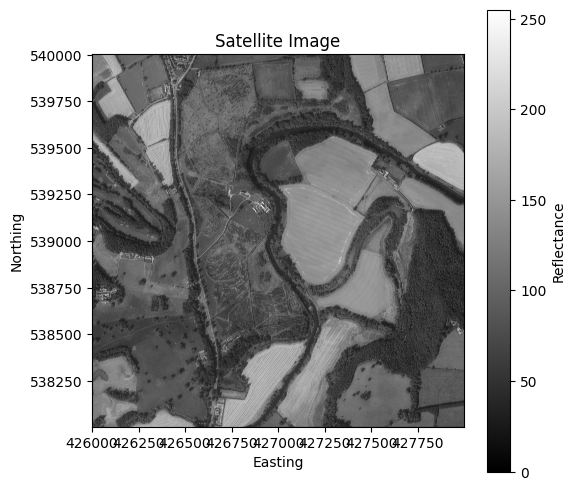

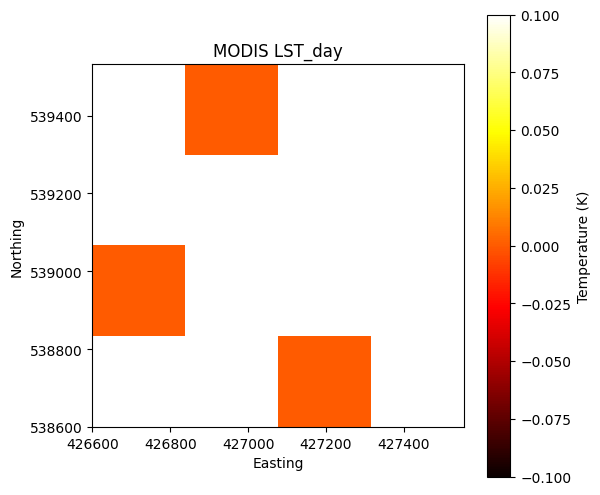

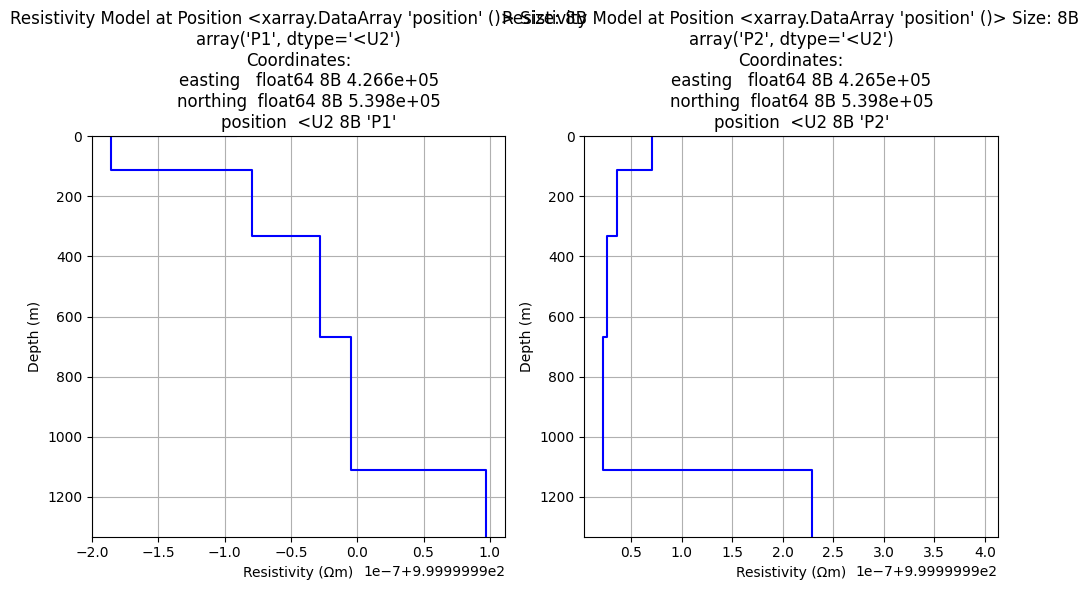

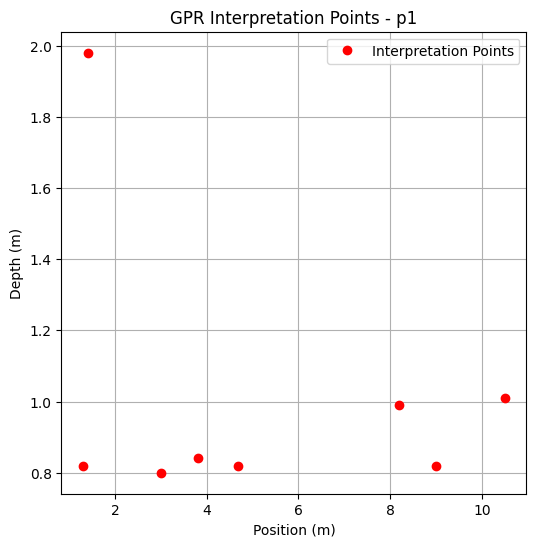

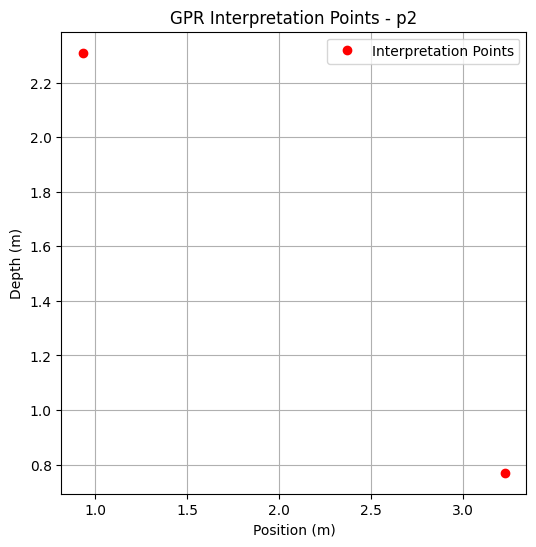

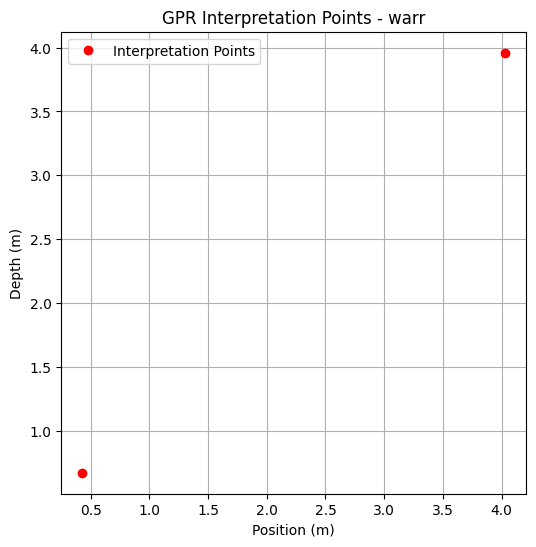

In [7]:
# Plot the satellite image
plt.figure(figsize=(6, 6))
plt.imshow(sat_img.values[0], cmap='gray', extent=[sat_img.easting.min(), sat_img.easting.max(), sat_img.northing.min(), sat_img.northing.max()])
plt.colorbar(label="Reflectance")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Satellite Image")
plt.show()

# Plot the MODIS data
plt.figure(figsize=(6, 6))
plt.imshow(modis_data.LST_day.isel(time=0), cmap='hot', extent=[modis_data.easting.min(), modis_data.easting.max(), modis_data.northing.min(), modis_data.northing.max()])
plt.colorbar(label="Temperature (K)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("MODIS LST_day")
plt.show()

# Plot the resistivity data
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
for i, pos in enumerate(resistivity.position):
    drawModel1D(ax[i], resistivity.sel(position=pos).attrs["depth_boundaries"], resistivity.sel(position=pos).values, color='b')
    ax[i].grid(True, which='both')
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_xlabel('Resistivity (Ωm)')
    ax[i].set_title(f"Resistivity Model at Position {pos}")
plt.tight_layout()
plt.show()

# Plot the GPR data
for key in interpretation_points:
    plt.figure(figsize=(6, 6))
    plt.plot(gpr_dataset[f"position_{key}"], gpr_dataset[f"depth_{key}"], 'ro', label="Interpretation Points")
    plt.xlabel("Position (m)")
    plt.ylabel("Depth (m)")
    plt.title(f"GPR Interpretation Points - {key}")
    plt.legend()
    plt.grid(True)
    plt.show()

## Stack multi-dimensional data layers - 2D image

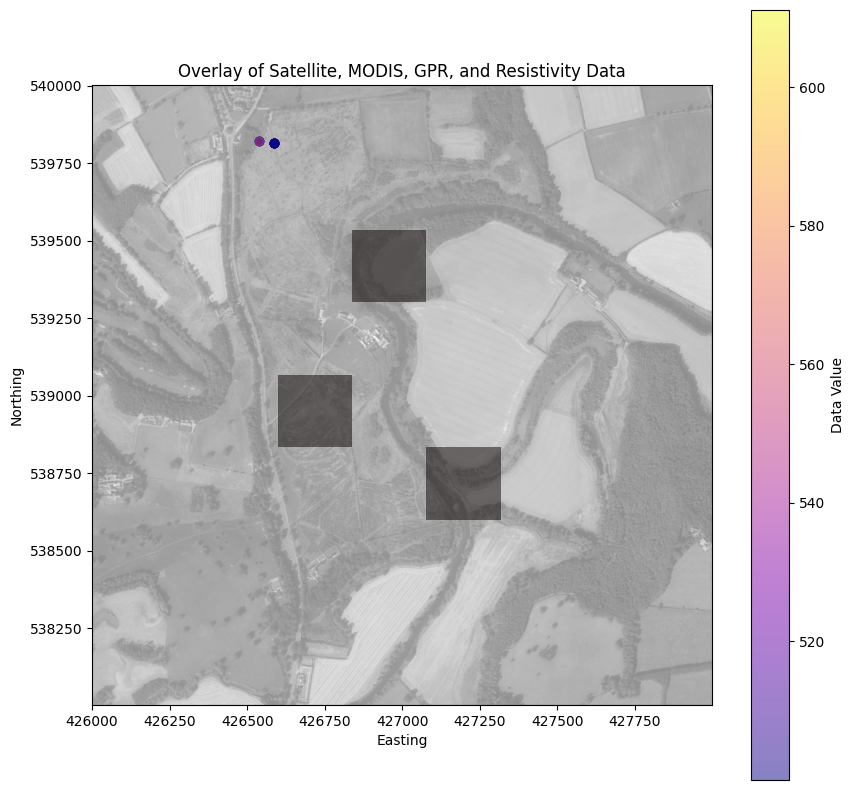

In [8]:
plt.figure(figsize=(10, 10))

# Sat Image
plt.imshow(sat_img.values[0], cmap='gray', extent=[sat_img.easting.min(), sat_img.easting.max(), sat_img.northing.min(), sat_img.northing.max()], alpha=0.5)

# MODIS
plt.imshow(modis_data.LST_day.isel(time=0), cmap='hot', extent=[modis_data.easting.min(), modis_data.easting.max(), modis_data.northing.min(), modis_data.northing.max()], alpha=0.5)

# GPR
for key in ['p1', 'p2', 'warr']:
    df = gpr_dataset[f'position_{key}']
    depth = gpr_dataset[f'depth_{key}']
    for i in range(len(df)):
        plt.scatter(df.easting, df.northing, c=depth[i], cmap='viridis', label=f'GPR {key.upper()}' if i == 0 else "", alpha=0.5)

# Resistivity
for pos in resistivity.position:
    easting = resistivity.sel(position=pos).easting.values
    northing = resistivity.sel(position=pos).northing.values
    depth_boundaries = resistivity.sel(position=pos).attrs['depth_boundaries']
    for depth in depth_boundaries:
        plt.scatter(easting, northing, c=depth, cmap='plasma', label=f'Resistivity at {pos}', alpha=0.5)

plt.colorbar(label="Data Value")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title("Overlay of Satellite, MODIS, GPR, and Resistivity Data")

plt.show()

## Rearrange data to the same coordinate system

In [9]:
# Resample the data
common_coords = {
    'easting': np.linspace(sat_img.easting.min(), sat_img.easting.max(), 100),
    'northing': np.linspace(sat_img.northing.min(), sat_img.northing.max(), 100)
}

sat_img_resampled = sat_img.interp(easting=common_coords['easting'], northing=common_coords['northing'], method='linear')
modis_resampled = modis_data.interp(easting=common_coords['easting'], northing=common_coords['northing'], method='linear')

# Create the depth coordinate
max_depth = max(resistivity.depth_boundaries.max(), gpr_dataset.depth_p1.max(), gpr_dataset.depth_p2.max(), gpr_dataset.depth_warr.max())
depth_coord = np.linspace(0, max_depth, 100)

resistivity_resampled = resistivity.interp(layer=depth_coord, method='linear', assume_sorted=True, kwargs={'fill_value': 'extrapolate'})

# Create the GPR data array
gpr_data_array = xr.DataArray(
    data=[gpr_dataset.depth_p1, gpr_dataset.depth_p2, gpr_dataset.depth_warr], 
    dims=['position', 'point'],
    coords={'position': ['P1', 'P2', 'WARR'], 'point': gpr_dataset.point}
)

gpr_resampled = gpr_data_array.interp(point=depth_coord, method='linear', assume_sorted=True, kwargs={'fill_value': 'extrapolate'})

## Stack multi-dimensional data layers - 3D interactive image

In [10]:
# Create the 3D arrays
easting, northing, depth = np.meshgrid(common_coords['easting'], common_coords['northing'], depth_coord, indexing='ij')

sat_img_3d = np.repeat(sat_img_resampled.values[np.newaxis, :, :], len(depth_coord), axis=0)
resistivity_3d = np.repeat(resistivity_resampled.values[np.newaxis, :, :], len(common_coords['northing']), axis=0)
gpr_3d = np.repeat(gpr_resampled.values[:, np.newaxis, :], len(common_coords['easting']), axis=1)

# Create the 3D arrays for MODIS
time_step = '2001-01-01'
modis_resampled_t = modis_resampled.sel(time=time_step)

# Create the 3D arrays for MODIS
modis_3d_arrays = {}
for var_name in modis_resampled_t.data_vars:
    modis_3d_arrays[var_name] = modis_resampled_t[var_name].expand_dims('depth').broadcast_like(resistivity_resampled)


In [11]:
# Create the 3D plot
fig = go.Figure(data=go.Volume(
    x=easting.flatten(),
    y=northing.flatten(),
    z=depth.flatten(),
    value=sat_img_3d.flatten(),
    isomin=0.0,
    isomax=237.0,
    opacity=0.5,
    surface_count=20,
    colorscale='Greys',
    name='Satellite Image'
))

# Add the MODIS data
for var_name, var_3d in modis_3d_arrays.items():
    fig.add_trace(go.Volume(
        x=easting.flatten(),
        y=northing.flatten(),
        z=depth.flatten(),
        value=var_3d.values.flatten(),
        isomin=0.0,
        isomax=237.0,
        opacity=0.1,
        surface_count=20,
        colorscale='Viridis',
        name=f'MODIS {var_name}'
    ))

# Add the resistivity data
resistivity_3d = np.repeat(resistivity_resampled.values[np.newaxis, :, :], len(common_coords['northing']), axis=0)
gpr_3d = np.repeat(gpr_resampled.values[:, np.newaxis, :], len(common_coords['easting']), axis=1)

fig.add_trace(go.Volume(
    x=easting.flatten(),
    y=northing.flatten(),
    z=depth.flatten(),
    value=resistivity_3d.flatten(),
    isomin=999,
    isomax=1001,
    opacity=0.5,
    surface_count=20,
    colorscale='Jet',
    name='Resistivity'
))

fig.add_trace(go.Volume(
    x=easting.flatten(),
    y=northing.flatten(),
    z=depth.flatten(),
    value=gpr_3d.flatten(),
    isomin=0,
    isomax=1000,
    opacity=0.5,
    surface_count=20,
    colorscale='Plasma',
    name='GPR'
))

fig.update_layout(
    scene=dict(
        xaxis_title='Easting',
        yaxis_title='Northing',
        zaxis_title='Depth'
    ),
    title="3D Data Cube Visualization"
)

fig.write_html('3d_graph.html')